# Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator <br>-- Correctness Testing --

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for variable density visco- acoustics using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are three notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Nonlinear Ops
- Implement the nonlinear modeling operations. 
- [ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)

##### 2. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Linearized Ops
- Implement the linearized (Jacobian) ```forward``` and ```adjoint``` modeling operations.
- [ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)

##### 3. Implementation of a Devito skew self adjoint variable density visco- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_03_iso_correctness.ipynb](ssa_03_iso_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for VTI and TTI anisotropy ([README.md](README.md)).

Below we describe a suite of unit tests that prove correctness for our *skew self adjoint* operators.

## Outline 
1. Define symbols [[link]](#c_symbols) 
2. Definition of correctness tests [[link]](#c_howto) 
1. Analytic response in the far field [[link]]("#c_analytic")
2. Modeling operator linearity test, with respect to source [[link]]("#c_F_linearity")
3. Modeling operator adjoint test, with respect to source [[link]]("#c_F_adjoint")
4. Nonlinear operator linearization test, with respect to model [[link]]("#c_F_linearization")
5. Jacobian operator linearity test, with respect to model [[link]]("#c_J_linearity")
6. Jacobian operator adjoint test, with respect to model [[link]]("#c_J_adjoint")
7. References [[link]]("#c_refs")


<a id="c_symbols"></a>
## Table of symbols

Note we are only showing the symbols here relevant to the correctness tests, for more detail on notations see the implementation notebooks that precede this one.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m(x,y,z)$ | Total P wave velocity ($m_0+\delta m$) | function of space |
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u(t,x,y,z)$ | Total pressure wavefield ($u_0+\delta u$)| function of time and space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $A\ u$ | Wave-equation operator | Linear in $u$: $\quad A\ u = s$ |
| $A^{-1} s$ | Wave-equation solution operator | Linear in $s$: $\quad A^{-1} s = u$ |
| $F[m]\ s$ | Restricted Forward modeling operator | Nonlinear in $m$, Linear in $s$: $\quad r = P_r\ A^{-1} P_s^\top\ s$ |
| $F[m]^\top\ r$ | Restricted Adjoint modeling operator | Nonlinear in $m$, Linear in $r$: $\quad s = P_s\ A^{-\top}\ P_r^\top\ r$ |
| $P_s$, $P_s^\top$ | Source interpolation operator, adjoint | Linear in $s$: $\quad s = P_s\ A^{-\top}\ P_r^\top\ r$ |
| $P_r$, $P_r^\top$ | Receiver interpolation operator, adjoint | Linear in $r$: $\quad r = P_r\ A^{-1} P_s^\top$ |
| $F[m; s]$ | Forward nonlinear modeling operator | Nonlinear in $[m; s]$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; s]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; s]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F\bigr)^\top[m; s]\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; s]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

<a id="c_howto"></a>
## Definition of correctness tests

We believe that if an operator passes the following suite of unit tests, it can be considered to be *righteous*.

## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We re-use the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook. 
<br>

## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$

<br>

## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

<br>

## 4. Nonlinear operator linearization test, with respect to model
For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease.

<br>

## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m]\ \delta m \\[5pt]
(\nabla F[m])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m])^\top \delta r
\end{aligned}
$$

<br>

## 6. Jacobian operator adjoint test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m]\ \delta m \approx \delta m \cdot (\nabla F[m])^\top \delta r
$$

<br>

## Skew symmetry test for shifted derivatives
In addition to these tests, recall that in the first notebook ([ssa_01_iso_implementation1.ipynb](ssa_01_iso_implementation1.ipynb)) we implemented a unit test that demonstrates skew symmetry of the Devito generated shifted derivatives. We include that test in our suite of unit tests for completeness. Please see the first notebook for that demonstration, verifying the following relation:

$$
x_2 \cdot \left( \overrightarrow{\partial_x}\ x_1 \right) \approx -\ 
x_1 \cdot \left( \overleftarrow{\partial_x}\ x_2 \right) 
$$

## Implementation of correctness tests

Below we implement the correctness tests described above. These tests are copied from standalone tests that run in the Devito project *continuous integration* (CI) pipeline. We will implement the test methods in one cell and then call from the next cell to verify correctness, but note that a wider variety of parameterization is tested in the CI pipeline.

For these tests we use the convenience functions implemented in ```operators.py``` and ```wavesolver.py``` rather than implement the operators in the notebook as we have in the first two notebooks in this series. Please review the source to compare with our notebook implementations:
- [operators.py](operators.py)
- [wavesolver.py](wavesolver.py)

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'

## Create a 2D model for testing

#### Model configuration:
- Total size (600,600)
- Interior size (500,500)
- Absorbing boundaries of 50 cells on all sides
- Source at the top left corner
- Line of receivers across top of model 1 cell below the source (excluding absorbing boundary)
- Constant velocity (1500 m/s) and constant density (1000 kg/m^3)
- Time range 2 seconds at sample rate defined by CFL stability
- $\frac{\omega}{Q}$ attenuation profile has $Q_p = 100$ in the interior and $Q_p = 0.1$ at exterior boundaries

In [2]:
# Discretization
dtype = np.float32
npad = 50
n = 601
d = 10.0 
shape = (n, n)
spacing = (d, d)
origin = (- d * npad, - d * npad)
extent = (d * (n - 1), d * (n - 1))

x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=d))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=d))
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)
space_order = 8

# Background velocity, velocity perturbation, and buoyancy
m0 = Function(name='m0', grid=grid, space_order=space_order)
m0.data[:] = 1.5

dm = Function(name='dm', grid=grid, space_order=space_order)
dm.data[npad:n-npad,npad:n-npad] = -1.0 + 2.0 * np.random.rand(n - 2 * npad, n - 2 * npad)

b = Function(name='b', grid=grid, space_order=space_order)
b.data[:] = 1 / 1000

# Attenuation profile
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 100.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_wOverQ(wOverQ, w, qmin, qmax, npad)

# Time range
dt = critical_dt(m0)
tmin = 0.0
tmax = 1000.0
time_axis = TimeAxis(start=tmin, stop=tmax, step=dt)
print(time_axis)

# Source and receivers
nr = shape[0] - 2 * npad
src = RickerSource(name='src', grid=grid, f0=fpeak, npoint=1, time_range=time_axis)
rec = Receiver(name='rec', grid=grid, npoint=nr, time_range=time_axis)

src.coordinates.data[0, 0] = 0.0
src.coordinates.data[0, 1] = 0.0

rec.coordinates.data[:, 0] = np.linspace(0.0, d * (nr - 1), nr)
rec.coordinates.data[:, 1] = np.ones(nr, dtype=np.float32) * d

print("")
print("shape;   ", shape)
print("origin;  ", origin)
print("spacing; ", spacing)
print("extent;  ", extent)

Allocating memory for m0(617, 617)
Allocating memory for dm(617, 617)
Allocating memory for b(617, 617)
Operator `WOverQ_Operator` generated in 0.07 s
  * lowering.Expressions: 0.03 s (46.2 %)
  * lowering.IET: 0.03 s (46.2 %)
     * specializing.IET: 0.02 s (30.8 %)
Flops reduction after symbolic optimization: [10 --> 10]
Allocating memory for wOverQ(617, 617)
Operator `WOverQ_Operator` fetched `/tmp/devito-jitcache-uid5138/49e43021289a7a0451d26b0c51977e749f7a4685.c` in 0.03 s from jit-cache
Operator `WOverQ_Operator` run in 0.01 s
* section0<601,601> with OI=2.50 computed in 0.01 s [1.06 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}
Allocating memory for src(478, 1)
Allocating memory for src_coords(1, 2)
Allocating memory for rec_coords(501, 2)


TimeAxis: start=0, stop=1001.7, step=2.1, num=478

shape;    (601, 601)
origin;   (-500.0, -500.0)
spacing;  (10.0, 10.0)
extent;   (6000.0, 6000.0)


## Plot the model

plt_extent;  [-500.0, 5500.0, 5500.0, -500.0]


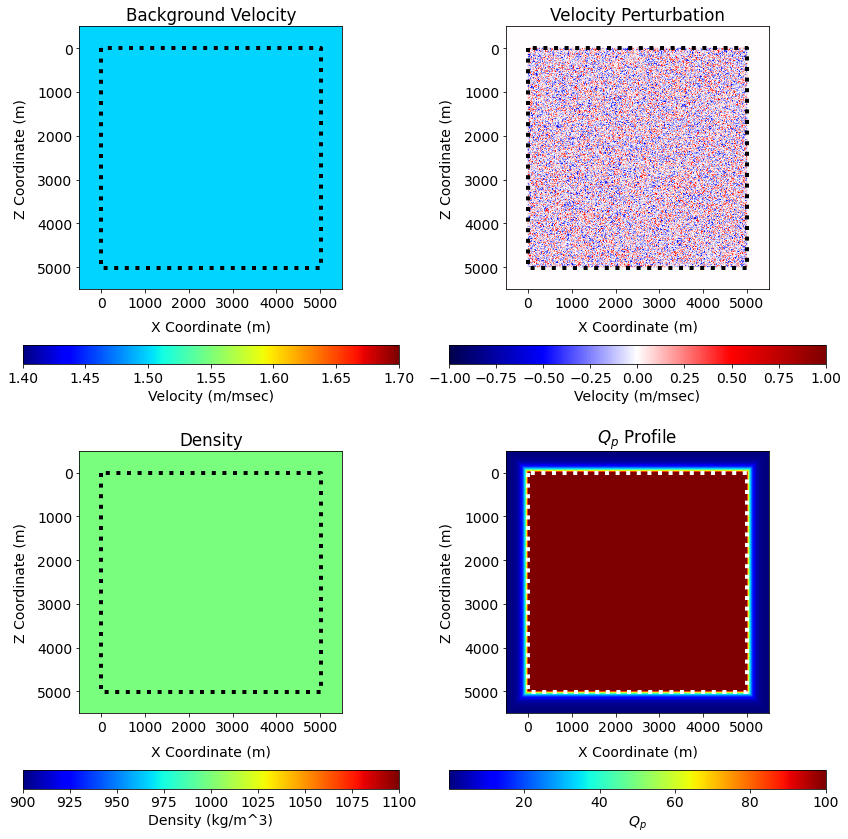

In [3]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + spacing[0]*(shape[0]-1), 
              origin[1] + spacing[1]*(shape[1]-1), origin[1]]

print("plt_extent; ", plt_extent)
vmin, vmax = 1.4, 1.7
pmin, pmax = -1, +1
bmin, bmax = 900, 1100

q = w / wOverQ.data[:]

b1 = 0.0
b2 = d * (n - 2 * npad)

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot([b1, b1, b2, b2, b1],
         [b1, b2, b2, b1, b1],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Background Velocity")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot([b1, b1, b2, b2, b1],
         [b1, b2, b2, b1, b1],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Velocity Perturbation")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.plot([b1, b1, b2, b2, b1],
         [b1, b2, b2, b1, b1],
         'black', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("Density")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(q.data), cmap=cm.jet,
           vmin=qmin, vmax=qmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='$Q_p$')
plt.plot([b1, b1, b2, b2, b1],
         [b1, b2, b2, b1, b1],
         'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.xlabel("X Coordinate (m)", labelpad=10)
plt.ylabel("Z Coordinate (m)", labelpad=10)
plt.title("$Q_p$ Profile")

plt.tight_layout()
None

<a id="c_analytic"></a>
## 1. Analytic response in the far field
Test that data generated in a wholespace matches analogous analytic data away from the near field. We re-use the material shown in the [examples/seismic/acoustic/accuracy.ipynb](https://github.com/devitocodes/devito/blob/master/examples/seismic/acoustic/accuracy.ipynb) notebook. 

<a id="c_F_linearity"></a>
## 2. Modeling operator linearity test, with respect to source
For random vectors $s$ and $r$, prove:

$$
\begin{aligned}
F[m]\ (\alpha\ s) &\approx \alpha\ F[m]\ s \\[5pt]
F[m]^\top (\alpha\ r) &\approx \alpha\ F[m]^\top r \\[5pt]
\end{aligned}
$$

<br>


<a id="c_F_adjoint"></a>
## 3. Modeling operator adjoint test, with respect to source
For random vectors $s$ and $r$, prove:

$$
r \cdot F[m]\ s \approx s \cdot F[m]^\top r
$$

<br>


<a id="c_F_linearization"></a>
## 4. Nonlinear operator linearization test, with respect to model
For initial velocity model $m$ and random perturbation $\delta m$ prove that the $L_2$ norm error in the linearization $E(h)$ is second order (decreases quadratically) with the magnitude of the perturbation.

$$
E(h) = \biggl\|\ f(m+h\ \delta m) - f(m) - h\ \nabla F[m]\ \delta m\ \biggr\|
$$

One way to do this is to run a suite of $h$ values decreasing by a factor of $\gamma$, and prove the error decreases by a factor of $\gamma^2$:  

$$
\frac{E\left(h\right)}{E\left(h/\gamma\right)} \approx \gamma^2
$$

Elsewhere in Devito tutorials, this relation is proven by fitting a line to a sequence of $E(h)$ for various $h$ and showing second order error decrease.

<br>


<a id="c_J_linearity"></a>
## 5. Jacobian operator linearity test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\begin{aligned}
\nabla F[m]\ (\alpha\ \delta m) &\approx \alpha\ \nabla F[m]\ \delta m \\[5pt]
(\nabla F[m])^\top (\alpha\ \delta r) &\approx \alpha\ (\nabla F[m])^\top \delta r
\end{aligned}
$$

<br>


<a id="c_J_adjoint"></a>
## 6. Jacobian operator adjoint test, with respect to model
For initial velocity model $m$ and random vectors $\delta m$ and $\delta r$, prove:

$$
\delta r \cdot \nabla F[m]\ \delta m \approx \delta m \cdot (\nabla F[m])^\top \delta r
$$

<br>


<a id="c_refs"></a>
## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
